F! Score: 57.47%

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.feature_selection import RFECV
import shap
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay 


C:\Users\nao\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<br><br>

First, I believe that the PAY_0...6 would be a strong predictor for default payment while ID and maybe sex will be a weak predictor. I will remove ID since it is just a number for each sample. Every other feature will most likely be useful in predicting the default payment. I will rename the features to make it easier to understand.

In [2]:
cc_data = pd.read_csv("UCI_Credit_Card.csv")
cc_data = cc_data.rename(columns = {'PAY_0':'REPAY_STATUS_SEPT', 'PAY_2': 'REPAY_STATUS_AUG', 'PAY_3': 'REPAY_STATUS_JULY', 'PAY_4': 'REPAY_STATUS_JUNE',
'PAY_5': 'REPAY_STATUS_MAY', 'PAY_6': 'REPAY_STATUS_APRIL'})
cc_data = cc_data.rename(columns = {'BILL_AMT1':'BILL_AMT_SEPT', 'BILL_AMT2': 'BILL_AMT_AUG', 'BILL_AMT3': 'BILL_AMT_JULY', 'BILL_AMT4': 'BILL_AMT_JUNE',
'BILL_AMT5': 'BILL_AMT_MAY', 'BILL_AMT6': 'BILL_AMT_APRIL'})
cc_data = cc_data.rename(columns = {'BILL_AMT1':'BILL_AMT_SEPT', 'BILL_AMT2': 'BILL_AMT_AUG', 'BILL_AMT3': 'BILL_AMT_JULY', 'BILL_AMT4': 'BILL_AMT_JUNE',
'BILL_AMT5': 'BILL_AMT_MAY', 'BILL_AMT6': 'BILL_AMT_APRIL'})
cc_data = cc_data.rename(columns = {'PAY_AMT1':'PREVPAY_AMT_SEPT', 'PAY_AMT2': 'PREVPAY_AMT_AUG', 'PAY_AMT3': 'PREVPAY_AMT_JULY', 'PAY_AMT4': 'PREVPAY_AMT_JUNE',
'PAY_AMT5': 'PREVPAY_AMT_MAY', 'PAY_AMT6': 'PREVPAY_AMT_APRIL'})

# I am getting rid of any row that has a repay status of -2 because it means that they do not have any bills to pay and isn't very helpful
# for my model

cc_data = cc_data[cc_data['REPAY_STATUS_SEPT'] != -2]
cc_data = cc_data[cc_data['REPAY_STATUS_AUG'] != -2]
cc_data = cc_data[cc_data['REPAY_STATUS_JULY'] != -2]
cc_data = cc_data[cc_data['REPAY_STATUS_JUNE'] != -2]
cc_data = cc_data[cc_data['REPAY_STATUS_MAY'] != -2]
cc_data = cc_data[cc_data['REPAY_STATUS_APRIL'] != -2]

categorical_features = ["EDUCATION", "MARRIAGE"]
for col in categorical_features:
    cc_data[col] = cc_data[col].astype(str)
    cc_data[col] = cc_data[col].astype(str)
cc_data
# make sure that the categorical values are strings. There was a problem with catboost saying that they were not strings but fixed with this change.

FileNotFoundError: [Errno 2] No such file or directory: 'UCI_Credit_Card.csv'

<!-- END QUESTION -->

<br><br>

In [4]:



X = cc_data.drop(columns = {"ID", "SEX", "default.payment.next.month"})
y = cc_data["default.payment.next.month"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123
)
bill_columns = ['BILL_AMT_APRIL', 'BILL_AMT_MAY', 'BILL_AMT_JUNE', 'BILL_AMT_JULY', 'BILL_AMT_AUG', 'BILL_AMT_SEPT']
negative_bills = (X_train[bill_columns] < 0).any()

# Display the columns that have negative bill amounts
negative_bills

# It seems that there are negative amounts, but we should not get rid of this as it may refer to refunds or another 
# special case and we will assume the data has no errors")

BILL_AMT_APRIL    True
BILL_AMT_MAY      True
BILL_AMT_JUNE     True
BILL_AMT_JULY     True
BILL_AMT_AUG      True
BILL_AMT_SEPT     True
dtype: bool

<!-- END QUESTION -->

<br><br>

Summary Statistic 1:
    Mean row for repayment:
        The mean for each month through April-September is less than 0. This indicates that most people pay their credit card bills on time.

Summary Statistic 2:
    Proportion of people that fail to pay their bills:
        Only about 22.12% of people in all the months combined fail to pay their credit card bills on time.
        
Visualization 1:
    Number of people paying on time for each month:
        This shows that most people pay on time each month but it seems that there are more people missing their payment as the months go by. 
        This is most likely because the people who delay their payment also delay their payment for the next months.
        
Visualization 2:
    The second visualization shows that the scaling is very different for each feature and we have to deal with that first.

The data shows a bit of imbalance since only a small percentage of people have default payment next month.

For this problem, I will use F1 score to deal the class imbalance. F1 score is the harmonic mean between precision and recall. This means that the model will not ignore the minority class.

In [5]:
repayment_columns = ['REPAY_STATUS_SEPT', 'REPAY_STATUS_AUG', 'REPAY_STATUS_JULY', 'REPAY_STATUS_JUNE', 'REPAY_STATUS_MAY', 'REPAY_STATUS_APRIL']

mean_row = X_train[repayment_columns].describe()

mean_row = mean_row.loc['mean']

print(mean_row)

prop = ((cc_data["default.payment.next.month"] == 1).sum() / 30000) * 100
print("Around %0.2f%% of people fail to pay their credit card bills on time." % prop)

missing_values = X_train.isnull().sum()
missing_values
# there is no missing data on the dataset

REPAY_STATUS_SEPT     0.177424
REPAY_STATUS_AUG      0.183702
REPAY_STATUS_JULY     0.169135
REPAY_STATUS_JUNE     0.123240
REPAY_STATUS_MAY      0.081002
REPAY_STATUS_APRIL    0.084964
Name: mean, dtype: float64
Around 17.95% of people fail to pay their credit card bills on time.


LIMIT_BAL             0
EDUCATION             0
MARRIAGE              0
AGE                   0
REPAY_STATUS_SEPT     0
REPAY_STATUS_AUG      0
REPAY_STATUS_JULY     0
REPAY_STATUS_JUNE     0
REPAY_STATUS_MAY      0
REPAY_STATUS_APRIL    0
BILL_AMT_SEPT         0
BILL_AMT_AUG          0
BILL_AMT_JULY         0
BILL_AMT_JUNE         0
BILL_AMT_MAY          0
BILL_AMT_APRIL        0
PREVPAY_AMT_SEPT      0
PREVPAY_AMT_AUG       0
PREVPAY_AMT_JULY      0
PREVPAY_AMT_JUNE      0
PREVPAY_AMT_MAY       0
PREVPAY_AMT_APRIL     0
dtype: int64

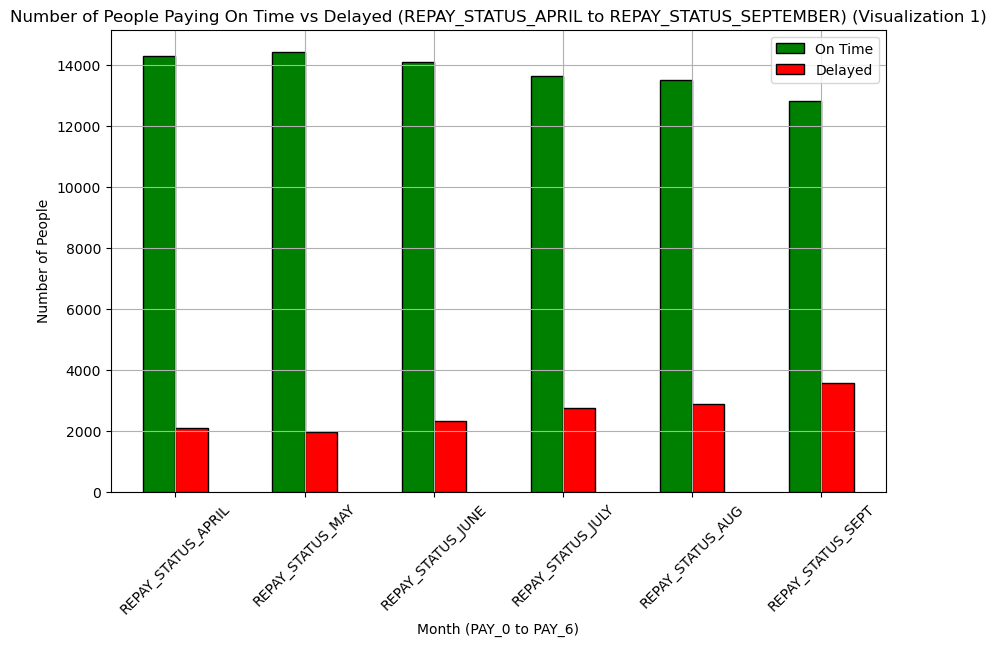

In [6]:
repayment_columns = ['REPAY_STATUS_APRIL', 'REPAY_STATUS_MAY', 'REPAY_STATUS_JUNE', 'REPAY_STATUS_JULY', 'REPAY_STATUS_AUG', 'REPAY_STATUS_SEPT']
repayment_category_counts_all = {}

for col in repayment_columns:
    repayment_category = np.where(X_train[col] <= 0, 'On Time', 'Delayed')
    repayment_category_counts_all[col] = pd.Series(repayment_category).value_counts()

repayment_category_df = pd.DataFrame(repayment_category_counts_all)

# Plot the bar chart for all PAY_0 to PAY_6
repayment_category_df.T.plot(kind='bar', figsize=(10, 6), color=['green', 'red'], edgecolor='black')
plt.title('Number of People Paying On Time vs Delayed (REPAY_STATUS_APRIL to REPAY_STATUS_SEPTEMBER) (Visualization 1)')
plt.xlabel('Month (PAY_0 to PAY_6)')
plt.ylabel('Number of People')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

array([[<Axes: title={'center': 'LIMIT_BAL'}>,
        <Axes: title={'center': 'AGE'}>,
        <Axes: title={'center': 'REPAY_STATUS_SEPT'}>,
        <Axes: title={'center': 'REPAY_STATUS_AUG'}>],
       [<Axes: title={'center': 'REPAY_STATUS_JULY'}>,
        <Axes: title={'center': 'REPAY_STATUS_JUNE'}>,
        <Axes: title={'center': 'REPAY_STATUS_MAY'}>,
        <Axes: title={'center': 'REPAY_STATUS_APRIL'}>],
       [<Axes: title={'center': 'BILL_AMT_SEPT'}>,
        <Axes: title={'center': 'BILL_AMT_AUG'}>,
        <Axes: title={'center': 'BILL_AMT_JULY'}>,
        <Axes: title={'center': 'BILL_AMT_JUNE'}>],
       [<Axes: title={'center': 'BILL_AMT_MAY'}>,
        <Axes: title={'center': 'BILL_AMT_APRIL'}>,
        <Axes: title={'center': 'PREVPAY_AMT_SEPT'}>,
        <Axes: title={'center': 'PREVPAY_AMT_AUG'}>],
       [<Axes: title={'center': 'PREVPAY_AMT_JULY'}>,
        <Axes: title={'center': 'PREVPAY_AMT_JUNE'}>,
        <Axes: title={'center': 'PREVPAY_AMT_MAY'}>,
      

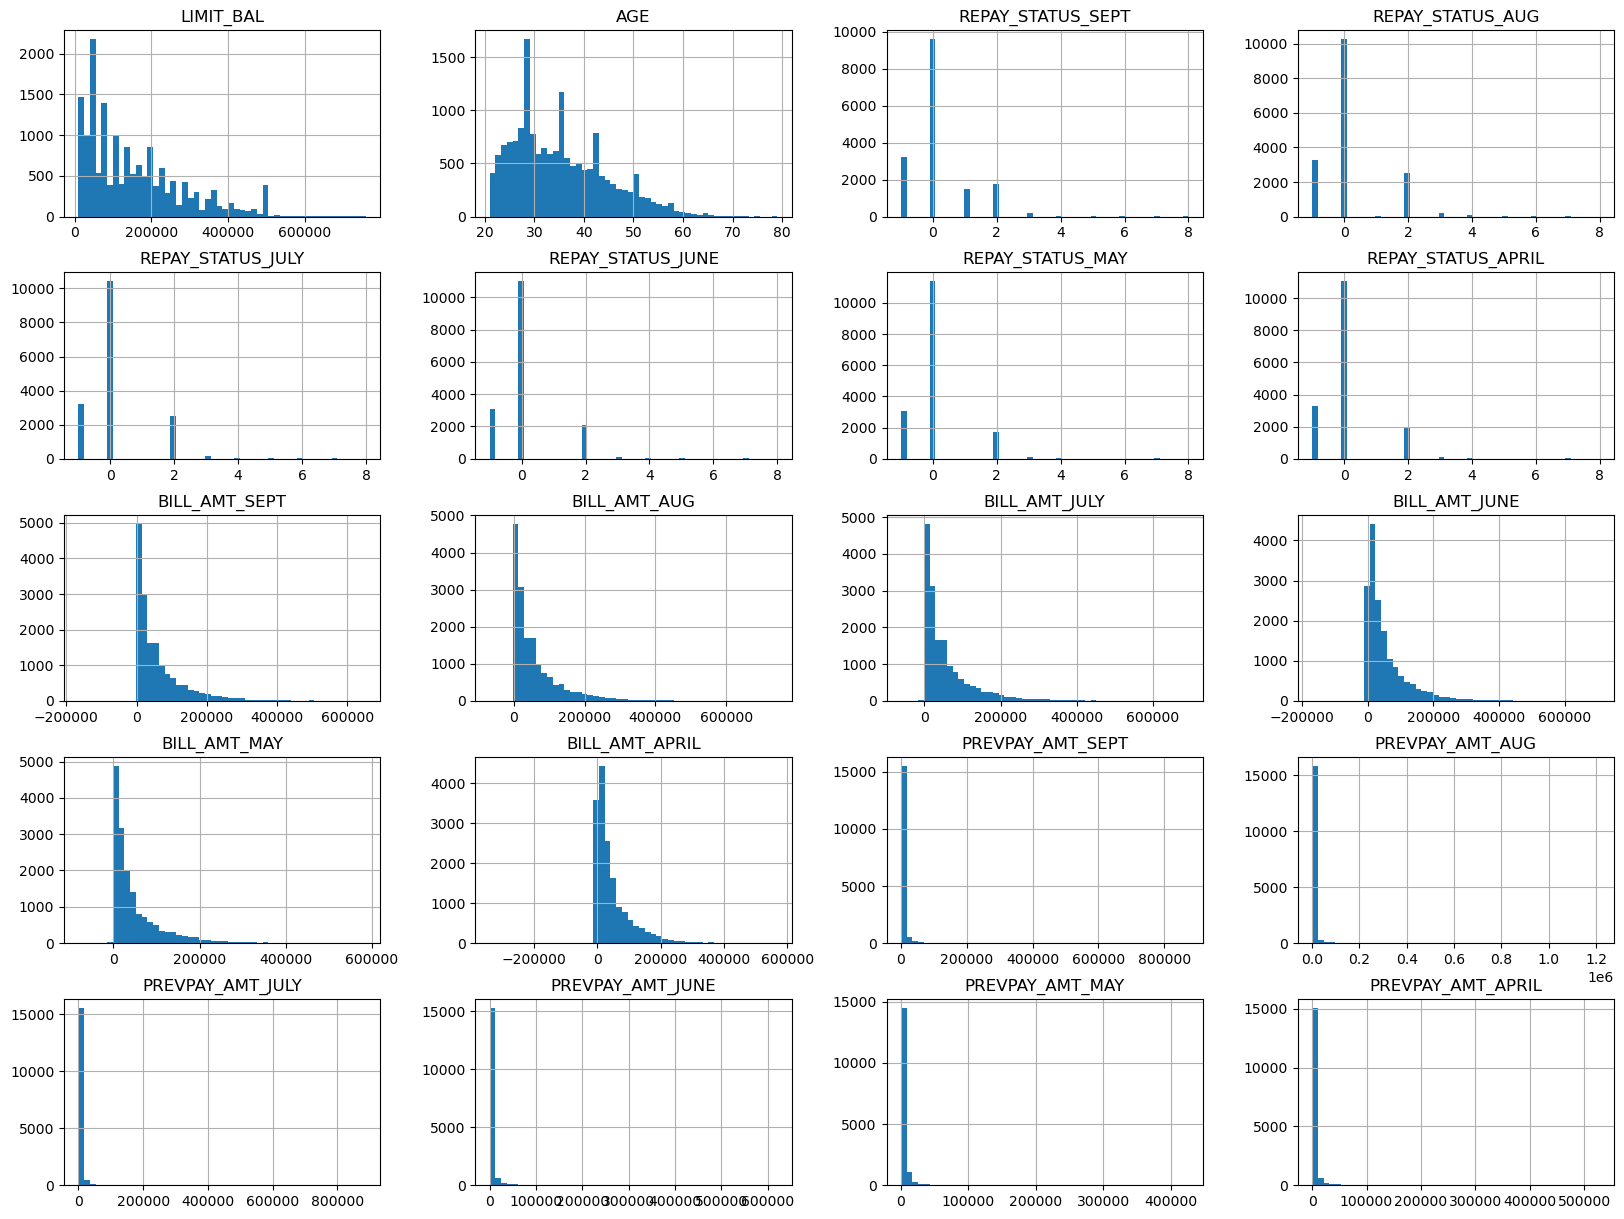

In [7]:
X_train.hist(bins=50, figsize=(20, 15))

<!-- END QUESTION -->

<br><br>

In [13]:
# total bill and total payment made
X_train['total_bill'] = X_train[['BILL_AMT_SEPT', 'BILL_AMT_AUG', 'BILL_AMT_JULY', 'BILL_AMT_JUNE', 'BILL_AMT_MAY', 'BILL_AMT_APRIL']].sum(axis=1)
X_train['total_payment'] = X_train[['PREVPAY_AMT_SEPT', 'PREVPAY_AMT_AUG', 'PREVPAY_AMT_JULY', 'PREVPAY_AMT_JUNE', 'PREVPAY_AMT_MAY', 'PREVPAY_AMT_APRIL']].sum(axis=1)

# how much of the credit is being used, total_bill / LIMIT_BAL
X_train['credit_utilization'] = X_train['total_bill'] / X_train['LIMIT_BAL']

# average payment delay
repayment_status_cols = ['REPAY_STATUS_SEPT', 'REPAY_STATUS_AUG', 'REPAY_STATUS_JULY', 'REPAY_STATUS_JUNE', 'REPAY_STATUS_MAY', 'REPAY_STATUS_APRIL']
X_train['avg_payment_delay'] = X_train[repayment_status_cols].mean(axis=1)

# this can show us the recent trends of payment
X_train['avg_last_three_months'] = (X_train['BILL_AMT_SEPT'] + X_train['BILL_AMT_AUG'] + X_train['BILL_AMT_JULY']) / 3

# this can also show us a trend of how much a persons bill is
X_train['billApr_May'] = X_train['BILL_AMT_APRIL'] - X_train['BILL_AMT_MAY']
X_train['billMay_June'] = X_train['BILL_AMT_MAY'] - X_train['BILL_AMT_JUNE']
X_train['billJune_July'] = X_train['BILL_AMT_JUNE'] - X_train['BILL_AMT_JULY']
X_train['billJuly_Aug'] = X_train['BILL_AMT_JULY'] - X_train['BILL_AMT_AUG']
X_train['billAug_Sept'] = X_train['BILL_AMT_AUG'] - X_train['BILL_AMT_SEPT']

X_train['last_three_repay'] = (X_train['PREVPAY_AMT_APRIL'] + X_train['PREVPAY_AMT_MAY'] + X_train['PREVPAY_AMT_JUNE']) / 3

# all of these features are helpful, informative, and relevant for this model. I will also do this on the testing data.

# repeat for the test data
X_test['total_bill'] = X_test[['BILL_AMT_SEPT', 'BILL_AMT_AUG', 'BILL_AMT_JULY', 'BILL_AMT_JUNE', 'BILL_AMT_MAY', 'BILL_AMT_APRIL']].sum(axis=1)
X_test['total_payment'] = X_test[['PREVPAY_AMT_SEPT', 'PREVPAY_AMT_AUG', 'PREVPAY_AMT_JULY', 'PREVPAY_AMT_JUNE', 'PREVPAY_AMT_MAY', 'PREVPAY_AMT_APRIL']].sum(axis=1)


X_test['credit_utilization'] = X_test['total_bill'] / X_test['LIMIT_BAL']

X_test['avg_payment_delay'] = X_test[repayment_status_cols].mean(axis=1)

X_test['avg_last_three_months'] = (X_test['BILL_AMT_SEPT'] + X_test['BILL_AMT_AUG'] + X_test['BILL_AMT_JULY']) / 3

X_test['billApr_May'] = X_test['BILL_AMT_APRIL'] - X_test['BILL_AMT_MAY']
X_test['billMay_June'] = X_test['BILL_AMT_MAY'] - X_test['BILL_AMT_JUNE']
X_test['billJune_July'] = X_test['BILL_AMT_JUNE'] - X_test['BILL_AMT_JULY']
X_test['billJuly_Aug'] = X_test['BILL_AMT_JULY'] - X_test['BILL_AMT_AUG']
X_test['billAug_Sept'] = X_test['BILL_AMT_AUG'] - X_test['BILL_AMT_SEPT']

X_test['last_three_repay'] = (X_test['PREVPAY_AMT_APRIL'] + X_test['BILL_AMT_MAY'] + X_test['BILL_AMT_JUNE']) / 3


X_test.replace([float('inf'), -float('inf')], value=0, inplace=True)

X_train

,LIMIT_BAL,EDUCATION,MARRIAGE,AGE,REPAY_STATUS_SEPT,REPAY_STATUS_AUG,REPAY_STATUS_JULY,REPAY_STATUS_JUNE,REPAY_STATUS_MAY,REPAY_STATUS_APRIL,...,total_payment,credit_utilization,avg_payment_delay,avg_last_three_months,billApr_May,billMay_June,billJune_July,billJuly_Aug,billAug_Sept,last_three_repay
18790,30000.0,2,1,28,0,0,0,0,0,0,...,9312.0,5.609067,0.000000,26612.000000,481.0,323.0,1225.0,1264.0,1270.0,1104.000000
13698,360000.0,1,2,31,-1,-1,0,0,-1,-1,...,24150.0,0.127722,-0.666667,11488.333333,3221.0,-2606.0,-3212.0,5463.0,-22249.0,4728.333333
13075,50000.0,1,2,29,-1,-1,0,0,0,0,...,74166.0,2.842440,-0.333333,23827.000000,8871.0,-12336.0,-3803.0,-5085.0,36540.0,11117.333333
15452,120000.0,1,2,27,0,0,2,0,0,0,...,21300.0,4.010292,0.333333,77737.000000,2015.0,954.0,1983.0,1453.0,2035.0,3400.000000
4474,120000.0,3,1,32,2,2,2,2,2,2,...,14000.0,3.525492,2.000000,68723.000000,1573.0,1322.0,1066.0,983.0,1340.0,1833.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19486,180000.0,1,1,28,0,0,0,0,0,0,...,37706.0,5.330306,0.000000,173866.333333,-3130.0,-38023.0,572.0,-1262.0,-3759.0,5000.000000
27601,20000.0,2,2,27,0,0,0,0,0,-1,...,28555.0,4.711150,-0.166667,17666.666667,3752.0,-802.0,-2005.0,-4086.0,262.0,8077.333333
22458,30000.0,1,1,41,0,0,0,0,0,0,...,7161.0,5.162333,0.000000,27344.333333,454.0,-7658.0,808.0,1117.0,1008.0,933.666667
19938,290000.0,2,1,45,0,0,0,0,0,0,...,9009.0,0.735190,0.000000,35881.666667,-913.0,-330.0,486.0,-860.0,-250.0,1337.000000


<!-- END QUESTION -->

<br><br>

In [14]:
filtered_rows = X_train[X_train['EDUCATION'].isin(["4", "5", "6"])]
num_rows = len(filtered_rows)
print("Number of rows with 4,5,6 education level: " , (num_rows / len(X_train)) * 100, "")

num_of_zeros = X_train[X_train['EDUCATION'].isin(["0"])]
print(len(num_of_zeros))

# since only about 1.5% of features display a education level of 5 or 6, I will combine those values and make them 5 (unknown)
# it also seems like there are examples where education is 0, which we will assume as unknown.

Number of rows with 4,5,6 education level:  1.2677515694520631 
4


In [15]:

# put features into groups
numeric_features = ['LIMIT_BAL',
                    'AGE', 
                    'BILL_AMT_SEPT',
                    'BILL_AMT_AUG',
                    'BILL_AMT_JULY',
                    'BILL_AMT_JUNE',
                    'BILL_AMT_MAY',
                    'BILL_AMT_APRIL',
                    'PREVPAY_AMT_SEPT',
                    'PREVPAY_AMT_AUG',
                    'PREVPAY_AMT_JULY',
                    'total_bill',
                    'total_payment',
                    'credit_utilization',
                    'avg_payment_delay',
                    'avg_last_three_months',
                    'billApr_May',
                    'billMay_June',
                    'billJune_July',
                    'billJuly_Aug',
                    'billAug_Sept',
                    'last_three_repay']

# education transformer 
class CombineEducationLevels(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['EDUCATION'] = np.where(X['EDUCATION'].isin(["0", "5", "6"]), "5", X['EDUCATION'])
        return X

    def get_feature_names_out(self, input_features=None):
        # Returns the feature names unchanged
        return input_features if input_features is not None else ["EDUCATION"]

education_transformer = CombineEducationLevels()
education = ['EDUCATION']
categorical_features = ['EDUCATION', 'MARRIAGE']


# transformers
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# set the order of repayment
repayment_order = [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
ordinal_transformer = OrdinalEncoder(categories=[repayment_order] * len(repayment_columns))

# preprocessor with transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('edu', education_transformer, education),
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('repay_ord', ordinal_transformer, repayment_columns)
    ]
)


X_train_fit_transform = preprocessor.fit_transform(X_train)
X_test_transform = preprocessor.transform(X_test)

<!-- END QUESTION -->

<br><br>

In [18]:
dummy = DummyClassifier(strategy="most_frequent")
pipe = make_pipeline(preprocessor, dummy)

scores = cross_validate(pipe, X_train, y_train, return_train_score=True, scoring = "f1")
pd.DataFrame(scores)
# Since we are looking at f1 score, we expect the test and train scores to be 0.

,fit_time,score_time,test_score,train_score
0,0.029839,0.008231,0.0,0.0
1,0.031853,0.007796,0.0,0.0
2,0.023430,0.007865,0.0,0.0
3,0.024218,0.007728,0.0,0.0
4,0.024558,0.007599,0.0,0.0


<!-- END QUESTION -->

<br><br>

Using logistic regression, the f1 score does not get much higher than 44% without C being too high and making the model more complex. The std score
very low which tells us that model's performance is consistent across the different cross-validation splits.

In [21]:
pipe_lr = make_pipeline(preprocessor, LogisticRegression(random_state=123))
param_grid = {'logisticregression__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
              'logisticregression__max_iter': [200, 300, 400, 500]
}


results_dict = {"logisticregression__C": [], "mean_cv_score": []}

grid_search = GridSearchCV(
    pipe_lr,
    param_grid=param_grid,
    cv=5,  
    n_jobs=-1,
    scoring = 'f1',
    return_train_score=True
)
grid_search.fit(X_train, y_train)

pd.DataFrame(grid_search.cv_results_)[
    [
        "mean_train_score",
        "mean_test_score",
        "std_test_score",
        "param_logisticregression__C",
        "param_logisticregression__max_iter",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().T

rank_test_score,1,1,1,1,5,5,5,5,9,9,...,25,25,29,29,29,29,33,33,33,33
mean_train_score,0.442820,0.442820,0.442820,0.442820,0.444967,0.444967,0.444967,0.444967,0.444974,0.444974,...,0.429707,0.429707,0.376585,0.376585,0.376585,0.376585,0.083922,0.083922,0.083922,0.083922
mean_test_score,0.443978,0.443978,0.443978,0.443978,0.443689,0.443689,0.443689,0.443689,0.443243,0.443243,...,0.427139,0.427139,0.376720,0.376720,0.376720,0.376720,0.084922,0.084922,0.084922,0.084922
std_test_score,0.007736,0.007736,0.007736,0.007736,0.007042,0.007042,0.007042,0.007042,0.006720,0.006720,...,0.005974,0.005974,0.009712,0.009712,0.009712,0.009712,0.020597,0.020597,0.020597,0.020597
param_logisticregression__C,0.100000,0.100000,0.100000,0.100000,1000.000000,1000.000000,1000.000000,1000.000000,100.000000,100.000000,...,0.010000,0.010000,0.001000,0.001000,0.001000,0.001000,0.000100,0.000100,0.000100,0.000100
param_logisticregression__max_iter,500.000000,400.000000,300.000000,200.000000,500.000000,400.000000,300.000000,200.000000,300.000000,500.000000,...,300.000000,200.000000,500.000000,400.000000,300.000000,200.000000,500.000000,400.000000,300.000000,200.000000
mean_fit_time,0.170968,0.152995,0.150077,0.188004,0.137216,0.138009,0.135569,0.144029,0.133729,0.153923,...,0.106104,0.095456,0.100249,0.084645,0.089234,0.099174,0.085512,0.083856,0.099037,0.103502


I have tried KNN, RandomForest, DecisionTree, and CatBoost. Knn had the worst performance and catboost had the best performance. 

In [24]:
pipe_knn = make_pipeline(preprocessor, KNeighborsClassifier())


pipe_knn.fit(X_train, y_train)

cv_results = cross_validate(
    pipe_knn,
    X_train,
    y_train,
    cv=5,
    scoring='f1',
    return_train_score=True
)
print(pd.DataFrame(cv_results))

   fit_time  score_time  test_score  train_score
0  0.035176    0.139743    0.470016     0.591038
1  0.032728    0.094356    0.467409     0.597069
2  0.033549    0.098817    0.476415     0.596861
3  0.036030    0.094208    0.487728     0.599681
4  0.032865    0.094334    0.452033     0.595038


There seems to be a drop from training and test scores so this probably means that the model is overfitting. The fit and score times are very quick compared to the other models we have tried.

In [25]:
pipe_rf = make_pipeline(
    preprocessor,
    RandomForestClassifier(
        random_state=123,
        class_weight='balanced'
    )
)

cv_results = cross_validate(
    pipe_rf,
    X_train,
    y_train,
    cv=5,
    scoring='f1',
    return_train_score=True
)
print(pd.DataFrame(cv_results))

   fit_time  score_time  test_score  train_score
0  3.253261    0.044778    0.493913     0.999663
1  3.257561    0.044863    0.487554     0.999663
2  3.244585    0.044924    0.466493     0.999831
3  3.300429    0.045590    0.472222     0.999663
4  3.231102    0.046024    0.461942     0.999831


The difference in train_score and test_score does not necessarily mean it is overfitting

In [26]:
pipe_tree = make_pipeline(preprocessor, DecisionTreeClassifier(random_state=123))

cv_results = cross_validate(
    pipe_tree,
    X_train,
    y_train,
    cv=5,
    scoring='f1',
    return_train_score=True
)
print(pd.DataFrame(cv_results))

   fit_time  score_time  test_score  train_score
0  0.429374    0.010380    0.413929     0.999831
1  0.405616    0.010096    0.414495     0.999831
2  0.414615    0.010251    0.427070     0.999831
3  0.398757    0.010987    0.402676     0.999663
4  0.410569    0.010034    0.428005     0.999831


We would have to do some hyperparametizer optimization for this to not overfit since the default max_depth is.

In [27]:
negative_class_count = np.sum(y_train == 0)
positive_class_count = np.sum(y_train == 1)

# Calculate scale_pos_weight as the ratio of negative to positive class
ratio = negative_class_count / positive_class_count

In [28]:
pipe_cb = make_pipeline(
    preprocessor,
    CatBoostClassifier(
        eval_metric='F1',       
        random_state=123,
        verbose=0               
    )
)


cv_results = cross_validate(
    pipe_cb,
    X_train,
    y_train,
    cv=5,
    scoring='f1',
    return_train_score=True
)
print(pd.DataFrame(cv_results))

   fit_time  score_time  test_score  train_score
0  5.311495    0.018221    0.532895     0.668839
1  4.943325    0.013579    0.518397     0.677843
2  4.516011    0.013000    0.502455     0.679678
3  4.641713    0.013349    0.523077     0.682453
4  4.757684    0.013065    0.514754     0.684932


This model doesn't over fit as excessively as the other models. The fit time though is much longer than the other models.

Using the previous hyperparameters we got from hyperparameter optimization, this does improve our model by about 6-7%. I will keep this feature selection in my pipeline as well. The other models seem to do better as well by a few percent.

In [29]:
lr_rfv = RFECV(
    estimator=LogisticRegression(max_iter = 300, C = 0.01, random_state=123),
    cv=5,
    scoring='f1',
    n_jobs=-1
)

pipe_lr = make_pipeline(preprocessor, lr_rfv)

cv_results = cross_validate(
    pipe_lr,
    X_train,
    y_train,
    cv=5,
    scoring='f1',
    return_train_score=True
)

print(pd.DataFrame(cv_results))

   fit_time  score_time  test_score  train_score
0  1.558568    0.008890    0.513746     0.493062
1  1.508602    0.013333    0.495255     0.497726
2  1.487994    0.008723    0.492119     0.498489
3  1.473539    0.008841    0.493007     0.498273
4  1.558231    0.009464    0.491859     0.498590


In [30]:
rfc_rfv = RFECV(
    estimator=RandomForestClassifier(random_state=123),
    cv=5,
    scoring='f1',
    n_jobs=-1
)

pipe_rfc = make_pipeline(preprocessor, rfc_rfv)

cv_results = cross_validate(
    pipe_rfc,
    X_train,
    y_train,
    cv=5,
    scoring='f1',
    return_train_score=True
)

print(pd.DataFrame(cv_results))

     fit_time  score_time  test_score  train_score
0  251.478447    0.054033    0.522463     0.999157
1  183.016239    0.051841    0.502914     0.999663
2  254.423219    0.051310    0.495033     0.999325
3  185.835942    0.047196    0.500818     0.999663
4  251.519105    0.045783    0.510391     0.998819


In [31]:
dt_rfv = RFECV(
    estimator=DecisionTreeClassifier(random_state=123),
    cv=5,
    scoring='f1',
    n_jobs=-1
)

pipe_dt = make_pipeline(preprocessor, dt_rfv)

cv_results = cross_validate(
    pipe_dt,
    X_train,
    y_train,
    cv=5,
    scoring='f1',
    return_train_score=True
)

print(pd.DataFrame(cv_results))

    fit_time  score_time  test_score  train_score
0  20.979935    0.008749    0.435185     0.998987
1  19.208555    0.020391    0.417871     0.999663
2  20.432261    0.010647    0.409718     0.999831
3  18.041003    0.009259    0.391683     0.999663
4  16.895764    0.016868    0.399740     0.999831


KNN does not have any coefficients like other models do so RFECV doesn't work here.

In [32]:
pipe_knn = make_pipeline(preprocessor, KNeighborsClassifier())

param_grid_knn = {
    'kneighborsclassifier__n_neighbors': list(range(1, 30, 2))
}

grid_search_knn = GridSearchCV(
    pipe_knn,
    param_grid=param_grid_knn,
    scoring='f1',
    cv=5,          
    n_jobs=-1,
    return_train_score=True
)

grid_search_knn.fit(X_train, y_train)

pd.DataFrame(grid_search_knn.cv_results_)[
    [
        "mean_train_score",
        "mean_test_score",
        "std_test_score",
        "param_kneighborsclassifier__n_neighbors",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().T

rank_test_score,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
mean_train_score,0.511793,0.510243,0.510355,0.528265,0.508953,0.506951,0.512108,0.517420,0.535445,0.520938,0.545849,0.595937,0.565080,0.668051,0.999798
mean_test_score,0.485781,0.484485,0.482483,0.482176,0.482005,0.481246,0.480329,0.480262,0.480063,0.479611,0.477481,0.470720,0.469451,0.454011,0.420369
std_test_score,0.013220,0.012367,0.013390,0.011488,0.011341,0.010616,0.014630,0.013235,0.009909,0.011823,0.011957,0.011682,0.012677,0.011036,0.006439
param_kneighborsclassifier__n_neighbors,21.000000,23.000000,25.000000,13.000000,27.000000,29.000000,19.000000,17.000000,11.000000,15.000000,9.000000,5.000000,7.000000,3.000000,1.000000
mean_fit_time,0.069574,0.073166,0.062688,0.062918,0.083091,0.088666,0.071803,0.077896,0.065144,0.061725,0.070126,0.068457,0.067872,0.083186,0.099038


In [33]:
X_train_transformed = preprocessor.fit_transform(X_train)

rfc_rfv = RFECV(
    estimator=RandomForestClassifier(random_state=123),
    cv=5,
    scoring='f1',
    n_jobs=-1
)

rfc_rfv.fit(X_train_transformed, y_train)

selected_features_mask = rfc_rfv.support_
X_train_selected = X_train_transformed[:, selected_features_mask]

param_grid_rf = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [None, 10, 20, 30, 40]
}

grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=123),
    param_grid=param_grid_rf,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    return_train_score=True
)

grid_search_rf.fit(X_train, y_train)

pd.DataFrame(grid_search_rf.cv_results_)[
    [
        "mean_train_score",
        "mean_test_score",
        "std_test_score",
        "param_n_estimators",
        "param_max_depth",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().T


rank_test_score,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
mean_train_score,0.683841,0.682667,0.684961,0.937473,0.999798,0.999798,0.682566,0.999798,0.93564,0.999798,0.999798,0.936146,0.934597,0.999798,0.99973,0.999798,0.998751,0.998751,0.999764,0.998074
mean_test_score,0.512846,0.51253,0.51023,0.507709,0.507135,0.506983,0.505969,0.505961,0.505801,0.504725,0.504495,0.504361,0.504132,0.504102,0.504013,0.503263,0.500038,0.49814,0.49773,0.496059
std_test_score,0.008783,0.011584,0.008984,0.006327,0.009114,0.008773,0.015722,0.010404,0.00842,0.007857,0.006966,0.010169,0.005024,0.009572,0.010871,0.009772,0.01623,0.016027,0.006893,0.012636
param_n_estimators,200,100,500,500,500,500,50,500,200,200,200,100,50,100,200,100,50,50,100,50
param_max_depth,10,10,10,20,None,30,10,40,20,40,None,20,20,None,30,40,40,None,30,30
mean_fit_time,8.046566,3.920185,20.554178,31.975358,31.789717,34.014481,1.988476,29.89957,12.778644,13.763472,12.304325,6.285083,3.151189,5.861178,13.73048,6.837084,3.448243,2.925903,6.760296,3.398329


In [34]:
X_train_transformed = preprocessor.fit_transform(X_train)

dt_rfv = RFECV(
    estimator=DecisionTreeClassifier(random_state=123),
    cv=5,
    scoring='f1',
    n_jobs=-1
)

dt_rfv.fit(X_train_transformed, y_train)

selected_features_mask = dt_rfv.support_
X_train_selected = X_train_transformed[:, selected_features_mask]

param_grid_tree = {
    'max_depth': list(range(1, 100, 10))
}

grid_search_tree = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=123),
    param_grid=param_grid_tree,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    return_train_score=True
)

grid_search_tree.fit(X_train_selected, y_train)

pd.DataFrame(grid_search_tree.cv_results_)[
    [
        "mean_train_score",
        "mean_test_score",
        "std_test_score",
        "param_max_depth",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().T


rank_test_score,1,2,3,4,5,6,6,6,6,6
mean_train_score,0.497228,0.687483,0.939596,0.999561,0.995557,0.999696,0.999696,0.999696,0.999696,0.999696
mean_test_score,0.497197,0.465947,0.429088,0.422846,0.420745,0.416886,0.416886,0.416886,0.416886,0.416886
std_test_score,0.008360,0.018767,0.020635,0.018973,0.008961,0.007915,0.007915,0.007915,0.007915,0.007915
param_max_depth,1.000000,11.000000,21.000000,41.000000,31.000000,51.000000,61.000000,71.000000,81.000000,91.000000
mean_fit_time,0.020051,0.178244,0.288998,0.313774,0.314025,0.313775,0.315246,0.317135,0.308964,0.293697


In [35]:
# did not use feature selection here because the it would cause problems and make my laptop crash.

pipe_cb = make_pipeline(
    preprocessor,
    CatBoostClassifier(
        eval_metric='F1',       
        random_state=123,
        verbose=0               
    )
)

param_grid_cb = {
    'catboostclassifier__n_estimators': [50, 100, 200, 500],
    'catboostclassifier__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'catboostclassifier__max_depth': [3, 4, 6, 8, 10],  
    'catboostclassifier__scale_pos_weight': [ratio]
}

grid_search_cb = GridSearchCV(
    pipe_cb,
    param_grid=param_grid_cb,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    return_train_score=True
)

grid_search_cb.fit(X_train, y_train)


pd.DataFrame(grid_search_cb.cv_results_)[
    [
        "mean_train_score",
        "mean_test_score",
        "std_test_score",
        "param_catboostclassifier__n_estimators",
        "param_catboostclassifier__learning_rate",
        "param_catboostclassifier__max_depth",
        "param_catboostclassifier__scale_pos_weight",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().T

rank_test_score,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
mean_train_score,0.675035,0.593174,0.620681,0.585820,0.578891,0.614688,0.582979,0.613855,0.602243,0.573868,...,0.830416,0.991575,0.997276,0.961697,0.965515,0.999798,0.974066,0.999124,0.999697,0.999798
mean_test_score,0.572432,0.572106,0.572071,0.571650,0.571402,0.570885,0.570878,0.570651,0.570637,0.570602,...,0.533137,0.526911,0.526709,0.526642,0.521194,0.519831,0.517829,0.515292,0.513224,0.508119
std_test_score,0.011841,0.010165,0.010373,0.009322,0.011791,0.012057,0.011919,0.012505,0.013024,0.011690,...,0.010691,0.009488,0.011837,0.012106,0.016397,0.009821,0.006746,0.015337,0.018495,0.015115
param_catboostclassifier__n_estimators,500.000000,200.000000,200.000000,100.000000,200.000000,100.000000,200.000000,500.000000,50.000000,50.000000,...,500.000000,200.000000,500.000000,200.000000,100.000000,500.000000,500.000000,200.000000,500.000000,500.000000
param_catboostclassifier__learning_rate,0.010000,0.010000,0.010000,0.010000,0.010000,0.050000,0.050000,0.010000,0.010000,0.050000,...,0.300000,0.200000,0.200000,0.300000,0.300000,0.200000,0.300000,0.300000,0.300000,0.300000
param_catboostclassifier__max_depth,10.000000,8.000000,10.000000,8.000000,6.000000,8.000000,4.000000,8.000000,10.000000,4.000000,...,4.000000,10.000000,8.000000,8.000000,10.000000,10.000000,6.000000,10.000000,8.000000,10.000000
param_catboostclassifier__scale_pos_weight,3.425951,3.425951,3.425951,3.425951,3.425951,3.425951,3.425951,3.425951,3.425951,3.425951,...,3.425951,3.425951,3.425951,3.425951,3.425951,3.425951,3.425951,3.425951,3.425951,3.425951
mean_fit_time,43.133633,6.186819,18.683856,2.815778,3.132794,2.703221,3.114629,18.410937,3.812469,1.058523,...,6.182117,18.518655,18.610432,5.252916,8.999774,38.686825,10.682895,18.780358,19.718049,30.619574


<!-- END QUESTION -->

<br><br>

For the CatBoost model, REPAY_STATUS_SEPT is the most important feature. Then, the feature that I added, avg_payment_delay is the second most 
important feature. Education and Marriage seem to not be a very important feature.

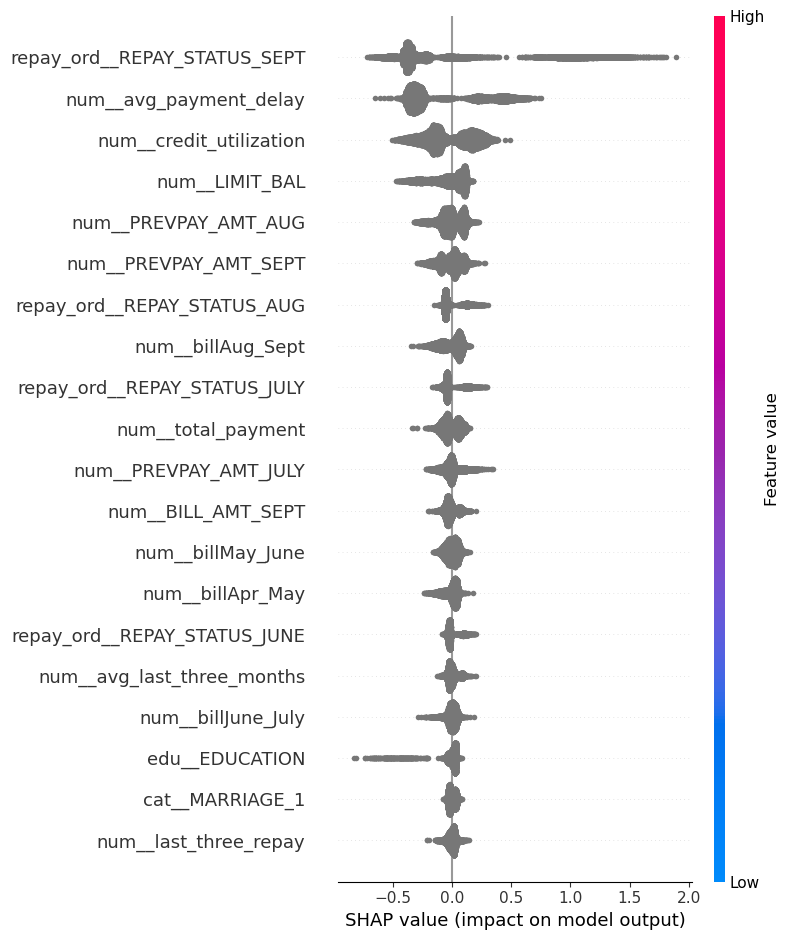

In [40]:
# get the best model and its hyperparameter
best_model = grid_search_cb.best_estimator_.named_steps['catboostclassifier']
best_model.fit(preprocessor.transform(X_train), y_train)

explainer = shap.TreeExplainer(best_model)

X_train_transformed = pd.DataFrame(preprocessor.transform(X_train))

feature_names = preprocessor.get_feature_names_out(X_train.columns)

shap_values = explainer.shap_values(X_train_transformed)

shap.summary_plot(shap_values, X_train_transformed, feature_names=feature_names)

2. The test scores do agree with my validation scores from before. They are almost the same f1 scores. My results are decently accurate but does not do very well on the minority class. It's performance on default cases may not be trusted but can be trusted for non-default cases. I don't believe i have encountered optimization bias as I used cross validation which reduces the risk of bias.

In [49]:
X_test_transformed = preprocessor.transform(X_test)


y_pred = best_model.predict(X_test_transformed)

print(f1_score(y_test, y_pred))

print("\nClassification Report:\n", classification_report(y_test, y_pred))

0.5740585774058578

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.84      0.85      5354
           1       0.54      0.61      0.57      1678

    accuracy                           0.78      7032
   macro avg       0.71      0.72      0.71      7032
weighted avg       0.79      0.78      0.79      7032



In [50]:
shap.initjs()

In [51]:
idx1 = 2
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)
X_test_transformed_df.iloc[idx1]

edu__EDUCATION                          2
num__LIMIT_BAL                  -0.045439
num__AGE                        -0.455242
num__BILL_AMT_SEPT              -0.500254
num__BILL_AMT_AUG               -0.502634
num__BILL_AMT_JULY              -0.443556
num__BILL_AMT_JUNE              -0.422968
num__BILL_AMT_MAY               -0.390212
num__BILL_AMT_APRIL             -0.356084
num__PREVPAY_AMT_SEPT           -0.353651
num__PREVPAY_AMT_AUG            -0.135202
num__PREVPAY_AMT_JULY           -0.323529
num__total_bill                 -0.459601
num__total_payment              -0.442997
num__credit_utilization          -0.85626
num__avg_payment_delay           1.280869
num__avg_last_three_months      -0.492693
num__billApr_May                 0.131835
num__billMay_June                0.170231
num__billJune_July               0.138761
num__billJuly_Aug                0.229256
num__billAug_Sept                0.045661
num__last_three_repay            1.061223
cat__EDUCATION_0                  

In [52]:
idx2 = 3
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)
X_test_transformed_df.iloc[idx2]

edu__EDUCATION                          1
num__LIMIT_BAL                  -0.834087
num__AGE                        -0.883913
num__BILL_AMT_SEPT              -0.547222
num__BILL_AMT_AUG               -0.550297
num__BILL_AMT_JULY              -0.498993
num__BILL_AMT_JUNE              -0.451864
num__BILL_AMT_MAY               -0.429679
num__BILL_AMT_APRIL             -0.399196
num__PREVPAY_AMT_SEPT           -0.353651
num__PREVPAY_AMT_AUG            -0.161193
num__PREVPAY_AMT_JULY           -0.206062
num__total_bill                  -0.50546
num__total_payment              -0.444985
num__credit_utilization         -0.107527
num__avg_payment_delay           2.109839
num__avg_last_three_months      -0.543647
num__billApr_May                 0.122902
num__billMay_June                0.145162
num__billJune_July               0.222388
num__billJuly_Aug                 0.21104
num__billAug_Sept                0.048346
num__last_three_repay            0.894058
cat__EDUCATION_0                  

In [53]:
feature_names = preprocessor.get_feature_names_out(input_features=X_train.columns)

X_test_enc = pd.DataFrame(preprocessor.transform(X_test), columns=feature_names, index=X_test.index)
X_train_enc = pd.DataFrame(preprocessor.transform(X_train), columns=feature_names, index=X_train.index)

explainer = shap.TreeExplainer(best_model)

train_shap_values = explainer.shap_values(X_train_enc)
test_shap_values = explainer.shap_values(X_test_enc)

shap.force_plot(explainer.expected_value, test_shap_values[idx1], X_test_enc.iloc[idx1, :])

We can see that avg_payment_delay is a large indicator for defaulting credit card bill.

In [54]:
feature_names = preprocessor.get_feature_names_out(input_features=X_train.columns)

X_test_enc = pd.DataFrame(preprocessor.transform(X_test), columns=feature_names, index=X_test.index)
X_train_enc = pd.DataFrame(preprocessor.transform(X_train), columns=feature_names, index=X_train.index)

explainer = shap.TreeExplainer(best_model)

train_shap_values = explainer.shap_values(X_train_enc)
test_shap_values = explainer.shap_values(X_test_enc)

shap.force_plot(explainer.expected_value, test_shap_values[idx2], X_test_enc.iloc[idx2, :])

Just like the previous example, this also has a large avg_payment_delay but at a greater magnitude.

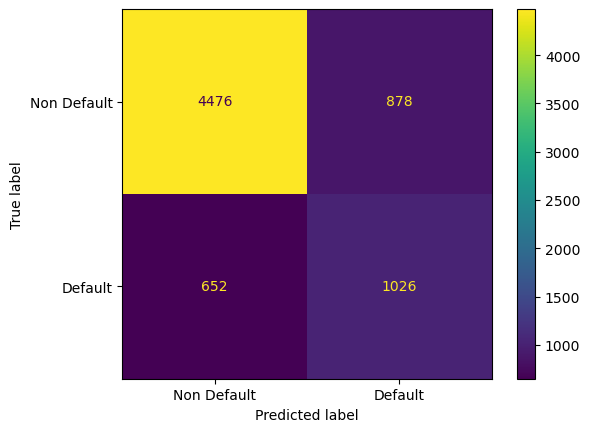

In [61]:
from sklearn.metrics import ConfusionMatrixDisplay
best_model.fit(X_train, y_train)
cm = ConfusionMatrixDisplay.from_estimator(
    best_model, X_test, y_test, values_format="d", display_labels=["Non Default", "Default"]
)

This model does not do very well with this data set as the f1 score is only around 54%. To improve the performance, I would have tried other models like LightGBM or XGBoost and if I was working on this outside of class, I would try using neural networks like how the study recommended. I would also try adding new features as that seemed to help my model quite a bit.

The models are all highly dependent on careful feature selection and a models score can deviate if the features are not well though out. Most of my time was spent trying to understand the data and come up with features. The quality of the data is very important as well and the information that is given to you about the data cannot always be trusted. you can never assume that the data consists only of the things mentioned by the creator of the data set. For example, The repay_status column had other values that weren't indicated on kaggle. We must always take a lot of time trying to understand the data in order to further improve our model. 

<!-- END QUESTION -->

<br><br>